In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
#read in data
ue = pd.read_csv('takehome_user_engagement.csv')
user = pd.read_csv('takehome_users.csv',encoding = "latin")

In [94]:
#inspect head
ue.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [95]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Given the above tables we are asked to build a model that predicts user adoption, defined as users who have logged in on three separate days within a 7 day window.  Given the problem statement, the task is defined as a binary classification problem.  Before we can procede we need to create the target label using the logins table by finding users that meet the adoption criteria. Once these users are found, they are merged with the users table as the target variable.

In [96]:
#convert to datetime
ue['time_stamp'] = pd.to_datetime(ue['time_stamp'])
#drop any duplicate rows
d = ue.drop_duplicates(subset='time_stamp')
#create date columns
d['date'] = d['time_stamp'].dt.date
#sort values by date
d = d.sort_values(by='date')

C:\Users\pseudo_bounce\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Creating Target Variable

Simply counting for three unique days within Sun - Sun will not achieve the desired result.  The calculation needs to be performed over a rolling 7 day window to capture true user adoptions. Pandas rolling function will work well here.  But first the data needs to be in the correct form.  After unsuccessfully trying group by operations to achieve the proper shape, I remembered pivot.

In [97]:
pivot = d.pivot_table(index='user_id',columns='date',values='visited')

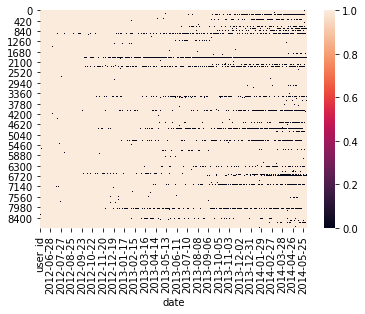

In [98]:
#reset index
v = pivot.reset_index()
#look at data as a heatmap
sns.heatmap(v.isnull())

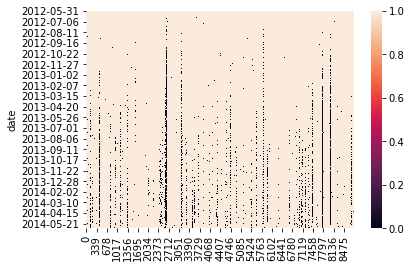

In [99]:
#transpose datafame so that users are columns
vtranspose = v.T
#drop user id
w = vtranspose.drop('user_id')
#inspect data
sns.heatmap(w.isnull())

In [100]:
# fill null values with 0
w = w.fillna(0)

#determining adopted users
adopted_users = []
for col in w.columns:
    # calculate the sum inside a 7 day rolling window and grab all users with sum >=3
    if sum(w[col].rolling(7).sum() >= 3):
        adopted_users.append(col)

In [101]:
print(f'Number of total users is {ue["user_id"].nunique()}')
print(f'Number of adopted users is {len(adopted_users)}')
print(f'Percentage of adopted users is {round((len(adopted_users) / ue["user_id"].nunique())*100,3)}%')

Number of total users is 8823
Number of adopted users is 1601
Percentage of adopted users is 18.146%


In [102]:
#create dataframe from adopted users list
adopted = pd.DataFrame()
#set object id (for merge) as the adopted users
adopted['object_id'] = adopted_users
#set adopted indicator
adopted['adopted'] = 1


In [103]:
#merge adopters users df to users df
df = user.merge(adopted, on = 'object_id',how='left')

In [104]:
#check merge.  Null values + the length of adopted users should equal len(df)
df['adopted'].isnull().sum() + len(adopted_users) == len(df)

True

In [105]:
#Fill null values with 0
df['adopted'].fillna(0,inplace=True)

### EDA

Now that the users table contains the target variable we can clean the data if needed, perform some eda, and engineer features that could be of use.

In [106]:
#inspect data
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [107]:
#look at datatypes
df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                       float64
dtype: object

In [108]:
#convert 'creation time' and 'last session creation time' to datetime objects
#last_session_creation_time is encoded as a float, convert to datetime
df['last_session_time'] = pd.to_datetime(df['last_session_creation_time'],unit='s')

#creation to encoded as string
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [109]:
#check for null values
df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                          0
last_session_time             3177
dtype: int64

In [110]:
#last session time was renamed to last session time at datetime conversion, drop last session creatoin time
df.drop('last_session_creation_time',axis=1,inplace=True)

In [111]:
#check value counts of invited by user is
sum(df['invited_by_user_id'].value_counts() < 2)

1097

#### Null Values

There are two columns with null values.  Null values account for roughly 20% of last session time.  However, this could be a useful column when trying to engineer features.  A quick method to fill the null values will be to use the most_common.  The invited by user id column will be dropped as almost half the data is missing and 1100 values have only recommended once.  

In [112]:
df.drop('invited_by_user_id',axis=1,inplace=True)

In [113]:
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,last_session_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1.0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,0.0,2014-03-31 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,0.0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,0.0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,0.0,2013-01-22 10:14:20


The available timestamp is too granular to find the most common day.  A copy of df is saved as df_date, null values are removed and the date is reformatted and saved in a list.  A counter object is used to create a dictionary in which the key (date) for the largest value is returned.  This value is then imputed into the last session time column.

In [114]:
dates = df_date['last_session_time'].dropna()

In [115]:
#loop through values and append reformatted dated to list
list_of_days = []
for row in dates:
    date = row.strftime('%m/%d/%Y')
    list_of_days.append(date)
    

In [116]:
from collections import Counter

In [117]:
from collections import Counter
#counter object for list of days
c = Counter(list_of_days)
#return key of max value and save to datefill
datefill = pd.to_datetime(max(c, key=c.get))

In [118]:
#fill null values
df['last_session_time'] = df['last_session_time'].fillna(datefill)

In [119]:
df.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
adopted                       0
last_session_time             0
dtype: int64

In [120]:
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,last_session_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1.0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,0.0,2014-03-31 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,0.0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,0.0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,0.0,2013-01-22 10:14:20


In [121]:
#Create new variables account age: latest date is set - creation time
#create a variable that captures the account age, with latest date as 'current'
df['last_day'] = '2014-05-30'
df['last_day'] = pd.to_datetime(df['last_day'])

#obtain account age
df['account_age'] = df['last_day'] - df['creation_time']

#grab the number of days from the timestamp
df['account_age'] = df['account_age'].dt.days


In [122]:
#Create new variables account history: last_session_time - creation time
df['account_history'] = df['last_session_time'] - df['creation_time']

#grab the number of days from the timestamp
df['account_history'] = df['account_history'].dt.days

In [123]:
df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'adopted', 'last_session_time', 'last_day', 'account_age',
       'account_history'],
      dtype='object')

In [124]:
#drop any columns where all values are unique in addition to date columns
cols_to_drop = ['creation_time','last_session_time','last_day','object_id','name','email']

In [125]:
df.drop(cols_to_drop,axis=1,inplace=True)

In [126]:
#convert target column to integer
df['adopted'] = df['adopted'].astype(int)

In [127]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_history
0,GUEST_INVITE,1,0,11,1,37,0
1,ORG_INVITE,0,0,1,0,195,136
2,ORG_INVITE,0,0,94,0,436,0
3,GUEST_INVITE,0,0,1,0,373,1
4,GUEST_INVITE,0,0,193,0,497,5


Text(0.5, 1.0, 'Counts of Creation Source')

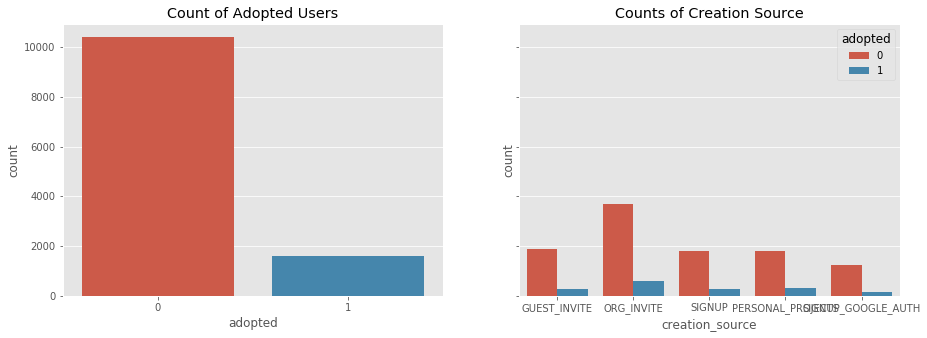

In [128]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.countplot(ax=axes[0], x=df['adopted'])
axes[0].set_title('Count of Adopted Users')

sns.countplot(data=df,x=df['creation_source'],hue='adopted')
axes[1].set_title('Counts of Creation Source')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

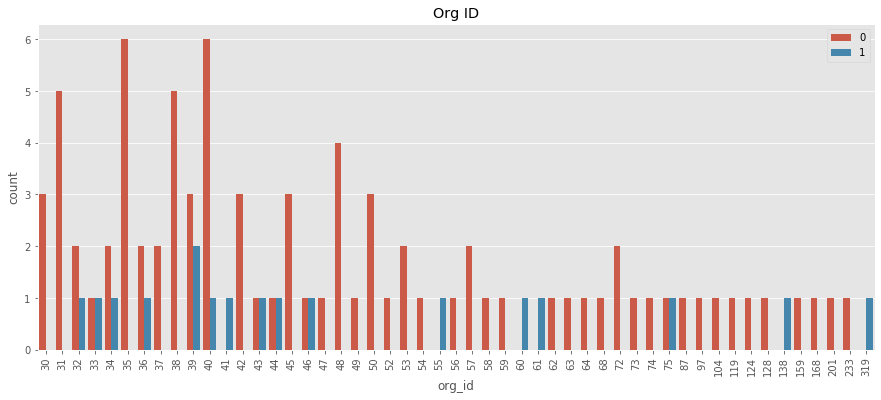

In [129]:
plt.figure(figsize=(15,6))
_ = sns.countplot(x=df['org_id'].value_counts().head(100),hue='adopted',data=df)
plt.legend(loc='upper right')
plt.title('Org ID')
plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'Enabled For Marketing Drip')

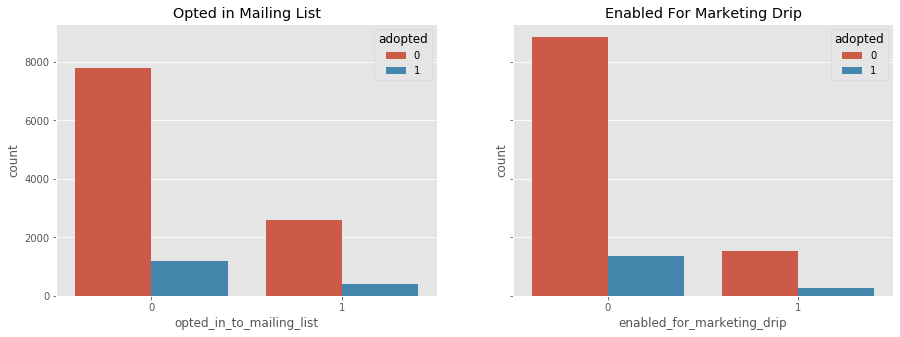

In [133]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.countplot(ax=axes[0],data=df, x=df['opted_in_to_mailing_list'],hue='adopted')
axes[0].set_title('Opted in Mailing List')

sns.countplot(data=df,x=df['enabled_for_marketing_drip'],hue='adopted')
axes[1].set_title('Enabled For Marketing Drip')

In [134]:
no_his = df[df['account_history'] == 0]

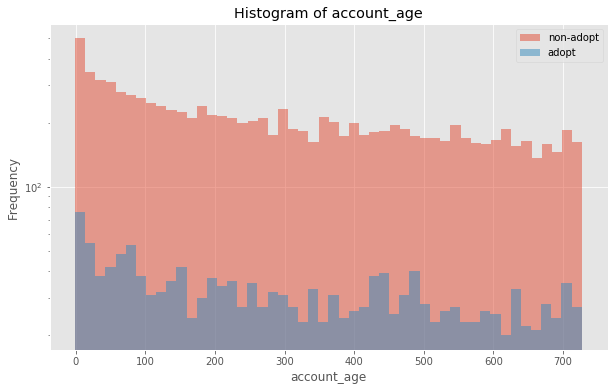

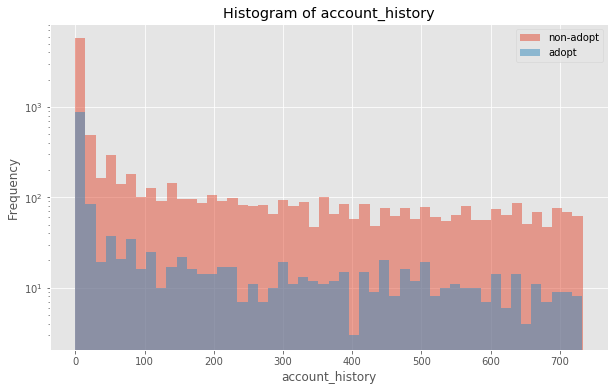

In [137]:
cols = ['account_age','account_history']
for col in cols:
    plt.figure(figsize=(10,6))
    plt.hist(df[df['adopted']==0][col], bins=50, alpha=0.5,label='non-adopt')
    plt.hist(df[df['adopted']==1][col], bins=50, alpha=0.5,label='adopt')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.yscale('log')
    #plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
    plt.show()

### Predictive Model

In [138]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_history
0,GUEST_INVITE,1,0,11,1,37,0
1,ORG_INVITE,0,0,1,0,195,136
2,ORG_INVITE,0,0,94,0,436,0
3,GUEST_INVITE,0,0,1,0,373,1
4,GUEST_INVITE,0,0,193,0,497,5


In [139]:
#Categorical encoding on the creation source column
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
cs_encode = ohe.fit_transform(df.creation_source.values.reshape(-1,1)).toarray()
df_hot = pd.DataFrame(cs_encode,columns=['cs_1','cs_2','cs_3','cs_4','cs_5'])
df_encode =pd.concat([df, df_hot], axis=1)

In [140]:
df_encode.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_history,cs_1,cs_2,cs_3,cs_4,cs_5
0,GUEST_INVITE,1,0,11,1,37,0,1.0,0.0,0.0,0.0,0.0
1,ORG_INVITE,0,0,1,0,195,136,0.0,1.0,0.0,0.0,0.0
2,ORG_INVITE,0,0,94,0,436,0,0.0,1.0,0.0,0.0,0.0
3,GUEST_INVITE,0,0,1,0,373,1,1.0,0.0,0.0,0.0,0.0
4,GUEST_INVITE,0,0,193,0,497,5,1.0,0.0,0.0,0.0,0.0


In [144]:
#convert float to int
columns=['cs_1','cs_2','cs_3','cs_4','cs_5']
for col in columns:
    df_encode[col] = df_encode[col].astype(int)


In [ ]:
df_encode.drop('creation_source',axis=1,inplace=True)

In [146]:
df_encode.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_history,cs_1,cs_2,cs_3,cs_4,cs_5
0,1,0,11,1,37,0,1,0,0,0,0
1,0,0,1,0,195,136,0,1,0,0,0
2,0,0,94,0,436,0,0,1,0,0,0
3,0,0,1,0,373,1,1,0,0,0,0
4,0,0,193,0,497,5,1,0,0,0,0


In [147]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, auc,roc_curve
from sklearn.model_selection import RandomizedSearchCV

In [148]:
df_encode.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'adopted', 'account_age', 'account_history', 'cs_1', 'cs_2', 'cs_3',
       'cs_4', 'cs_5'],
      dtype='object')

In [149]:
#create train and test sets
X = df_encode[['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
               'account_age', 'account_history', 'cs_1', 'cs_2', 'cs_3',
               'cs_4', 'cs_5']]

y = df_encode['adopted']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=1618,test_size=.20)

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=1618, class_weight='balanced')
# parameter list for grid search
params = {'n_estimators': [10, 50, 100, 200]}

model = GridSearchCV(clf, params)
model.fit(X_train, y_train)

print('Best parameters were', model.best_params_)


Best parameters were {'n_estimators': 10}


In [161]:
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

In [152]:
#get classification report, convert to dataframe
report = classification_report(y_test,preds,output_dict=True)
report_random_forest = pd.DataFrame(report).transpose()
report_random_forest

,precision,recall,f1-score,support
0,0.868275,0.90000,0.883853,2080.000
1,0.147541,0.11250,0.127660,320.000
accuracy,0.795000,0.79500,0.795000,0.795
macro avg,0.507908,0.50625,0.505756,2400.000
weighted avg,0.772177,0.79500,0.783027,2400.000


In [153]:
confusion_matrix(y_test,preds)

array([[1872,  208],
       [ 284,   36]], dtype=int64)

In [154]:
fi = model.best_estimator_.feature_importances_
df_imp = pd.DataFrame(data=fi,index=X_train.columns).sort_values(by=0,ascending=False)

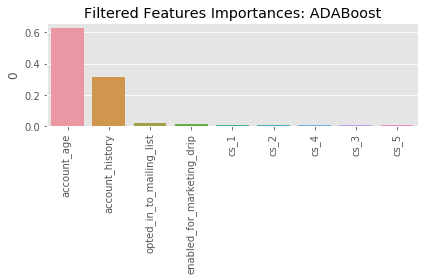

In [160]:
sns.barplot(x=df_imp.index,y=df_imp[0])
plt.title("Filtered Features Importances: Random Forest")
plt.xticks(rotation=90)
plt.tight_layout()

In [164]:
y_probs = probs[:,1]

In [165]:
roc_auc_score(y_test,y_probs)

0.48116962139423075